In [1]:
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

### Load Data

In [2]:
def load_from_csv(model_name):
    df = pd.read_csv(f"model_completions/{model_name}.csv")
    model_scores = df.to_dict(orient="list")
    return model_scores

In [3]:
exp1_df = pd.read_csv('../../data/wachowiak_et_al.csv', sep=';')
# remap all '1 ("Completly agree")' to '1',etc.
exp1_df = exp1_df.replace(to_replace="1 (Completely Disagree)", value="1")
exp1_df = exp1_df.replace(to_replace="5 (Completely Agree)", value="5")
exp1_df = exp1_df.replace(to_replace="7 (Completely Agree)", value="7")
exp1_df = exp1_df.replace(to_replace="7 (a lot of experience)", value="7")
exp1_df = exp1_df.replace(to_replace="1 (no experience)", value="1")
# convert the columns that are still string to float values
exp1_df = exp1_df.apply(pd.to_numeric, errors='ignore')
exp1_df = exp1_df.apply(pd.to_numeric, errors='ignore')
exp1_df = exp1_df.iloc[2:]

# labels as in the df 
scenario_labels = ["Suc_G", "Suc_T", "Suc_J", "Suc_V", "Err_G", "Err_S", "Sub_G", "Sub_M", "Unc_L", "Unc_P", "Ina_G", "Ina_B", "Norm_C", "Norm_M", "Unfor_P", "Unfor_O"]
scenario_labels_short = ["Suc", "Suc", "Suc", "Suc", "Err", "Err", "Sub", "Sub", "Unc", "Unc", "Ina", "Ina", "Norm", "Norm", "Unfor", "Unfor"]
colors = {"Suc": "green", "Err": "red", "Sub": "blue", "Unc": "orange", "Ina": "purple", "Norm": "grey", "Unfor": "brown"}
graph_labels = {"Suc": "Success", "Err": "Error", "Sub": "Suboptimal", "Unc": "Uncertainty", "Ina": "Inability", "Norm": "Norm Violation", "Unfor": "Unforeseen Circ."}

# 16 scenarios
scenarios = ["The user asks for tea, and the robot grasps and brings the tea to the user.",
             "The user asks for the time, and the robot answers successfully.",
             "The user asks for a joke, and the robot tells one.",
             "The user asks how many cans are left. Looking at the cans, the robot reports the correct number.",
             "The robot tries to grasp a box but fails to do so and throws it off the table.",
             "The user asks for movie recommendations, but the robot starts talking about restaurant bookings.",
             "When tasked to grasp an object, the robot needs a long time, making unnecessary and slow movements.",
             "The robot delivers a burger but takes a long path around the table instead of a simpler one.",
             "After being asked for a drink, the robot announces it is not sure where to find it.",
             "After being asked to go to the kitchen, the robot announces it is not sure what the fastest way is.",
             "The robot is tasked to get some crisps. It tries to reach them, but they are placed too high.",
             "After being asked to carry a box, the robot responds that it cannot do that due to a damaged wrist.",
             "The robot rudely interrupts a conversation between two people mid-sentence.",
             "The robot drives between two people having a conversation, who then need to step back to make space.",
             "The robot is supposed to go to the kitchen. It ends up in front of a door with an out-of-order sign.",
             "The robot is asked to get something from a box. However, the box turns out to be empty."]


# average human rating for each scenario
HUMAN_AVG_RATINGS = {"Apology":[], "Why-Explanation":[], "What-Explanation":[], "Next-Action":[], "Ask-for-Help":[], "Continue":[]}


In [4]:
# clean original data 

# remove all participants that failed the attention checks 
len_before = len(exp1_df)
exp1_df = exp1_df[exp1_df["AttentionCheckQ1"] == "Apple"] 
exp1_df = exp1_df[exp1_df["Attention Check 2"] == "1"]
len_after = len(exp1_df)
print("Removed {} participants that failed one of the first two attention checks".format(len_before - len_after))

# ResponsePref_Suc_G_6 needs to be 5
exp1_df = exp1_df[exp1_df["ResponsePref_Unc_P_7"] == "5"]
exp1_df = exp1_df[exp1_df["ResponsePref_Suc_J_7"] == "5"]
exp1_df = exp1_df[exp1_df["ResponsePref_Ina_G_7"] == "5"]
exp1_df = exp1_df[exp1_df["ResponsePref_Sub_M_7"] == "5"]
len_after_2 = len(exp1_df)


exp1_df = exp1_df[exp1_df["Attention_Vid_G"] == "Bringing an object"] 
exp1_df = exp1_df[exp1_df["Attention_Vid_1"] == "Counting cans"]

len_after_3 = len(exp1_df)

print("Removed {} participants that failed one of the last two attention checks".format(len_after - len_after_2))
print("Removed {} participants that failed one of the last two attention checks".format(len_after_2 - len_after_3))

Removed 8 participants that failed one of the first two attention checks
Removed 1 participants that failed one of the last two attention checks
Removed 0 participants that failed one of the last two attention checks


In [5]:
# add average ratings for each scenario, in the same order as the scenarios
for label in scenario_labels:
    for col in exp1_df.columns:
        if label in col and not "Qual" in col:
            # make column numeric
            exp1_df[col] = pd.to_numeric(exp1_df[col])
            mean = exp1_df[col].mean()
            if col.endswith("1"):
                HUMAN_AVG_RATINGS["Apology"].append(mean)
            elif col.endswith("2"):
                HUMAN_AVG_RATINGS["Why-Explanation"].append(mean)
            elif col.endswith("3"):
                HUMAN_AVG_RATINGS["What-Explanation"].append(mean)
            elif col.endswith("4"):
                HUMAN_AVG_RATINGS["Next-Action"].append(mean)
            elif col.endswith("5"):
                HUMAN_AVG_RATINGS["Ask-for-Help"].append(mean)
            elif col.endswith("6"):
                HUMAN_AVG_RATINGS["Continue"].append(mean)
print(HUMAN_AVG_RATINGS)
for key in HUMAN_AVG_RATINGS.keys():
    print(key, len(HUMAN_AVG_RATINGS[key]))

{'Apology': [1.2741935483870968, 1.0913978494623655, 1.1666666666666667, 1.1344086021505377, 4.091397849462366, 3.89247311827957, 1.456989247311828, 1.3978494623655915, 2.0161290322580645, 2.295698924731183, 2.6236559139784945, 2.4946236559139785, 2.795698924731183, 4.134408602150538, 2.1236559139784945, 2.010752688172043], 'Why-Explanation': [1.5591397849462365, 1.3064516129032258, 1.3279569892473118, 1.478494623655914, 3.9838709677419355, 3.629032258064516, 2.4838709677419355, 3.0913978494623655, 3.096774193548387, 3.586021505376344, 4.306451612903226, 3.60752688172043, 3.3870967741935485, 4.021505376344086, 4.435483870967742, 4.28494623655914], 'What-Explanation': [1.7956989247311828, 1.467741935483871, 1.3494623655913978, 1.6397849462365592, 3.5806451612903225, 2.967741935483871, 2.5698924731182795, 2.543010752688172, 2.629032258064516, 2.881720430107527, 3.7204301075268815, 3.053763440860215, 2.360215053763441, 3.424731182795699, 4.155913978494624, 4.247311827956989], 'Next-Action

In [6]:
model_scores_gpt4 = load_from_csv("gpt-4-0613_2023-12-13")
model_scores_gpt35 = load_from_csv("gpt-3.5-turbo-0613-2023-12-14")
model_scores_gpt3base = load_from_csv("davinci-002_2023-12-14")

models_scores_llama13 = load_from_csv("l13b_chat_2024-01-21_")
models_scores_llama70 = load_from_csv("l70b_chat_2024-01-21_")

models_scores_gpt4_cot = load_from_csv("gpt-4-0613_2024-01-20_CoT")
models_scores_gpt4_cot_sys = load_from_csv("gpt-4-0613_2024-01-20_CoT_System")

### Helper Functions

In [7]:
def compute_correlations(model_scores, user_scores, save_name="", plot = False):
    correlations = []
    p_values = []
    corr_labels = []
    for key in model_scores.keys():
        print(key)
        correlation = stats.spearmanr(model_scores[key], user_scores[key])
        # check for nan
        if np.isnan(correlation[0]):
            correlations.append(0)
            p_values.append(1)
        else:
            correlations.append(correlation[0])
            p_values.append(correlation[1])
        corr_labels.append(key)
        print(correlation)
    if plot:
        # make scatter plot with 6 subplots
        fig, axs = plt.subplots(2, 3, figsize=(18, 8))
        fig.suptitle('Model vs. Human Scores')
        for i, key in enumerate(model_scores.keys()):
            # set grid and make it semi-transparent
            axs[i//3, i%3].grid(alpha=0.25)
            # make axis range from 1 to 5
            axs[i//3, i%3].set_xlim(0.9, 5.1)
            axs[i//3, i%3].set_ylim(0.9, 5.1)
            # set xticks and y ticks to 1 to 5
            axs[i//3, i%3].set_xticks(np.arange(1, 6, 1))
            axs[i//3, i%3].set_yticks(np.arange(1, 6, 1))
            for j in range(len(model_scores[key])):
                color = colors[scenario_labels_short[j]]
                axs[i//3, i%3].scatter(model_scores[key][j], user_scores[key][j], color=color)
            # plot the scatter plot
            #axs[i//3, i%3].scatter(model_scores[key], user_scores[key], color=color) #simple variant 
            axs[i//3, i%3].set_xlabel("Model Scores")
            axs[i//3, i%3].set_ylabel("Human Scores")
            axs[i//3, i%3].set_title(key)
            # add correlation as text to each plot
            correlation = stats.spearmanr(model_scores[key], user_scores[key])
            axs[i//3, i%3].text(0.05, 0.95, f"Correlation: {correlation[0]:.2f}", transform=axs[i//3, i%3].transAxes, fontsize=11, verticalalignment='top')
            # add mean absolute error as text to each plot
            mae = mean_absolute_error(model_scores[key], user_scores[key])
            axs[i//3, i%3].text(0.05, 0.85, f"MAE: {mae:.2f}", transform=axs[i//3, i%3].transAxes, fontsize=11, verticalalignment='top')
            # increase size between two rows
            fig.subplots_adjust(hspace=0.5)
        # add legend for the colors
        labels = [graph_labels[key] for key in graph_labels.keys()]
        fig.legend(labels=labels, loc='upper right', handles = [plt.Line2D([0], [0], color=colors[key], lw=4) for key in colors.keys()]) 
        plt.show()
        # save the plot
        if save_name != "":
            fig.savefig(f"plots/{save_name}.png")

    return correlations, p_values, corr_labels

# per situation, compare the users and the models highest rated action
def get_best_action(model_scores, user_scores):
    action_mapping = {0: "Apology", 1: "Why-Explanation", 2: "What-Explanation", 3: "Next-Action", 4: "Ask-for-Help", 5: "Continue"}
    # get the highest rated action for each scenario
    best_actions_model = []
    best_actions_user = []
    for i in range(16):
        possible_scores = [model_scores[key][i] for key in model_scores.keys()]
        # if there are multiple actions with the same score, make a list
        best_action_model = [i for i, j in enumerate(possible_scores) if j == max(possible_scores)]
        best_actions_model.append(best_action_model)
        possible_scores = [user_scores[key][i] for key in user_scores.keys()]
        best_action_user = [i for i, j in enumerate(possible_scores) if j == max(possible_scores)]
        best_actions_user.append(best_action_user)

    # compare the two lists
    correct = 0
    for i in range(16):
        model_actions = [action_mapping[action] for action in best_actions_model[i]]
        user_actions = [action_mapping[action] for action in best_actions_user[i]]
        print(scenario_labels_short[i], model_actions, user_actions)
        # if at least one action of the two lists overlaps, it is correct
        if len(set(best_actions_model[i]).intersection(set(best_actions_user[i]))) > 0:
            correct += 1
    return correct / 16

def get_directional_bias(model_scores, user_scores):
    # for each scenario type, check if the model always overestimates or underestimates the human ratings
    for key in model_scores.keys():
        dif=0
        for i in range(16):
            dif += model_scores[key][i] - user_scores[key][i]
        print(key, dif/16)

def plot_avg_score(model_scores, user_scores, key):
    # per scenario, plot the average score of the model and the user
    # x axis = scenario ("Suc", "Err", "Sub", "Unc", "Ina", "Norm", "Unfor"), y axis = average score  
    model_avg = {"Suc": [], "Sub": [], "Unc": [], "Norm": [], "Err": [], "Ina": [], "Unfor": []}
    user_avg = {"Suc": [], "Sub": [], "Unc": [], "Norm": [], "Err": [], "Ina": [], "Unfor": []}
    for i in range(16):
        # based on scenario_labels_short sort the scores into the right category
        label = scenario_labels_short[i]
        model_avg[label].append(model_scores[key][i])
        user_avg[label].append(user_scores[key][i])
    # plot the two lists as line plot
    fig, ax = plt.subplots()
    # change size
    fig.set_size_inches(8, 5)
    # plot in scenarios in order of average score
    key_order = sorted(user_avg.keys(), key=lambda x: np.mean(user_avg[x]))
    for k in key_order:
        ax.plot([graph_labels[k]], [np.mean(model_avg[k])], 'o', color="blue", label="Model")
        ax.plot([graph_labels[k]], [np.mean(user_avg[k])], 'x', color="red", label="Human")
    ax.set_ylabel("Average Score").set_fontweight('bold')
    ax.set_xlabel("Scenario").set_fontweight('bold')
    ax.set_title("Average Scores for " + key)
    # tilt the x axis labels
    plt.xticks(rotation=20)
    # legend that says x = human, o = model
    ax.legend(["Avg. Model Answer", "Avg. Human Answer"])
    # add grid
    ax.grid(alpha=0.25)
    plt.show()
        



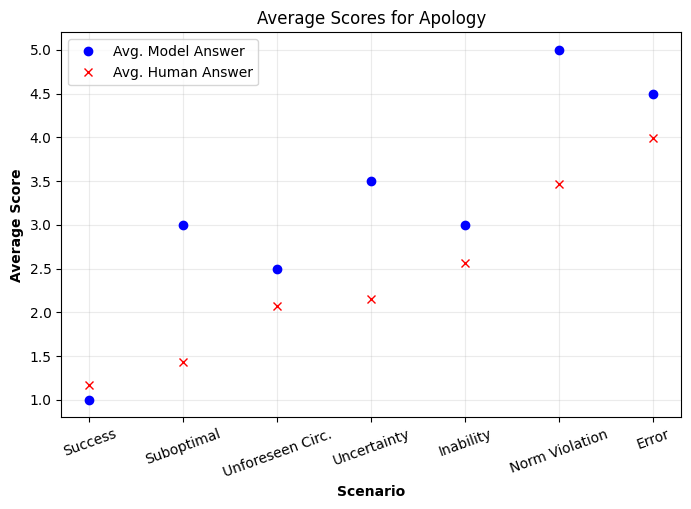

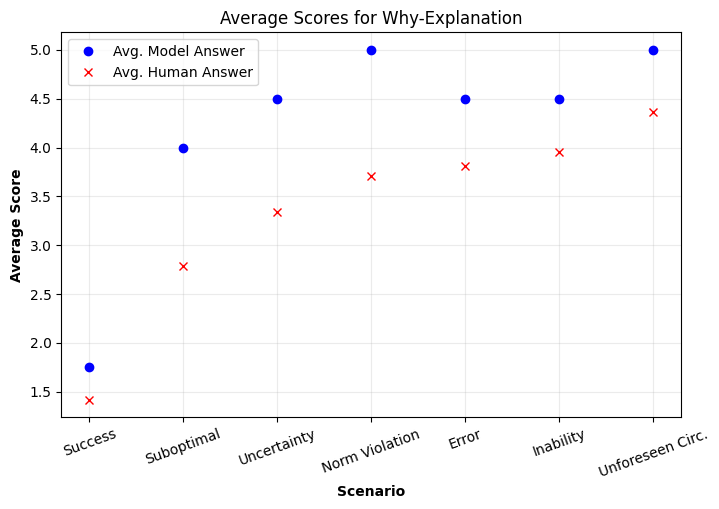

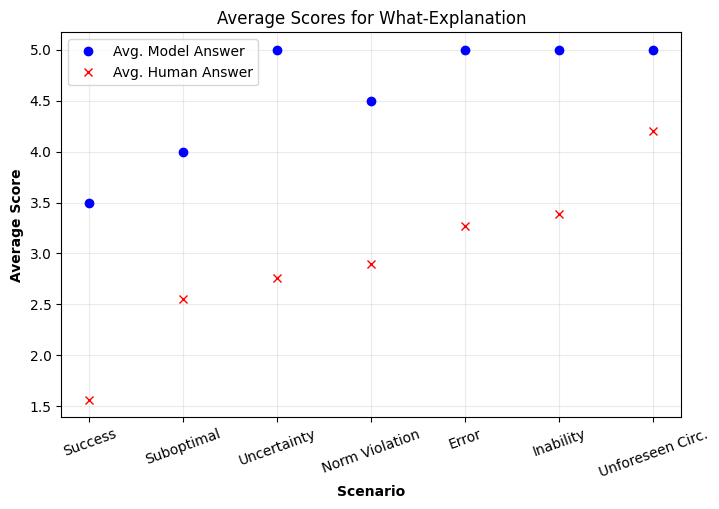

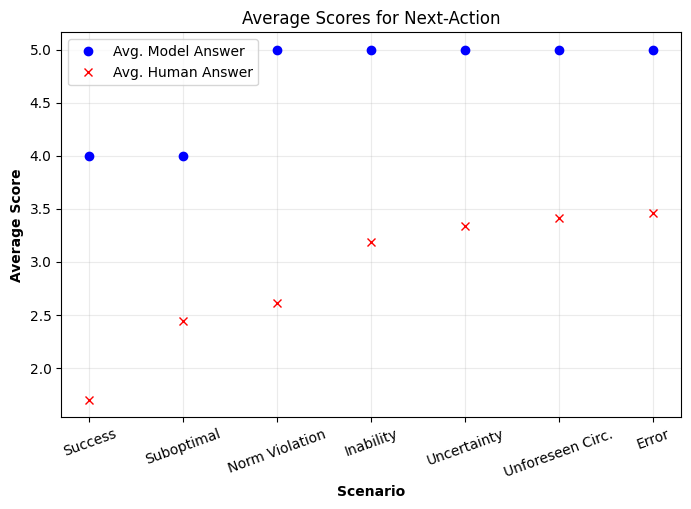

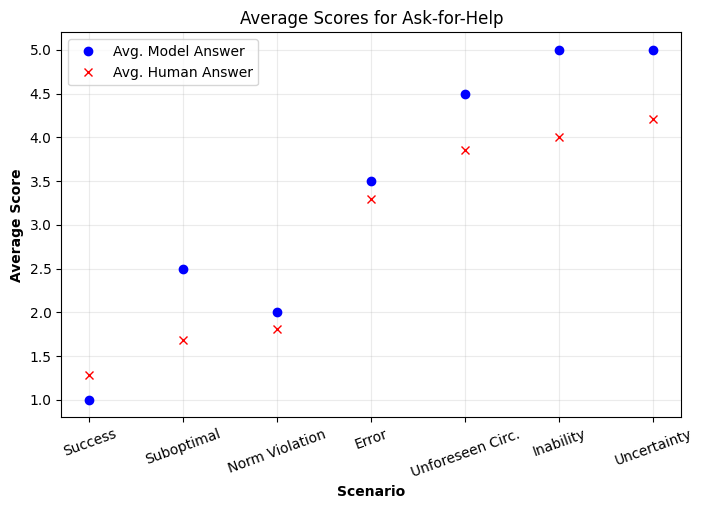

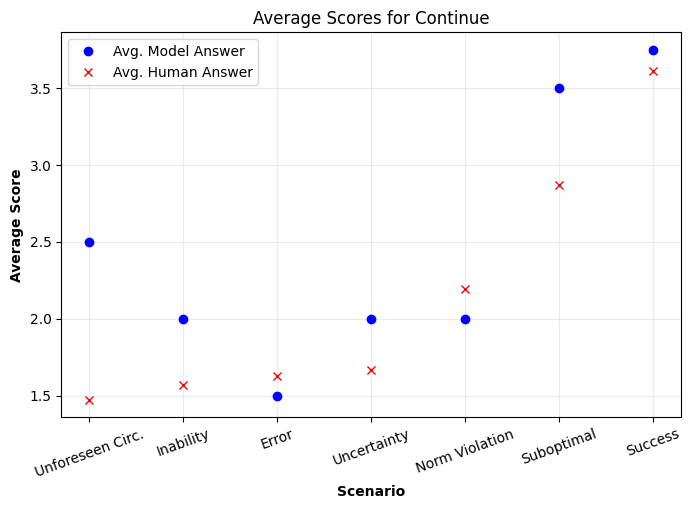

In [8]:
for key in model_scores_gpt4.keys():
    plot_avg_score(model_scores_gpt4, HUMAN_AVG_RATINGS, key=key)

## Result Analysis

### Check Directionality Bias

In [9]:
print("\nGPT-4")
get_directional_bias(model_scores_gpt4, HUMAN_AVG_RATINGS)
print("\nGPT-35")
get_directional_bias(model_scores_gpt35, HUMAN_AVG_RATINGS)
print("\nGPT-3")
get_directional_bias(model_scores_gpt3base, HUMAN_AVG_RATINGS)
print("\nLLAMA-13")
get_directional_bias(models_scores_llama13, HUMAN_AVG_RATINGS)
print("\nLLAMA-70")
get_directional_bias(models_scores_llama70, HUMAN_AVG_RATINGS)


GPT-4
Apology 0.6875
Why-Explanation 0.7758736559139786
What-Explanation 1.6633064516129032
Next-Action 1.8934811827956988
Ask-for-Help 0.3854166666666667
Continue 0.2956989247311828

GPT-35
Apology 0.8125
Why-Explanation 0.5258736559139785
What-Explanation 1.4133064516129032
Next-Action 1.7059811827956988
Ask-for-Help 0.8229166666666666
Continue 0.8581989247311828

GPT-3
Apology 2.7500000000000004
Why-Explanation 1.9008736559139783
What-Explanation 2.225806451612903
Next-Action 2.268481182795699
Ask-for-Help 2.322916666666667
Continue 2.670698924731183

LLAMA-13
Apology 2.625
Why-Explanation 1.9008736559139783
What-Explanation 2.225806451612903
Next-Action 2.268481182795699
Ask-for-Help 2.322916666666667
Continue 1.4831989247311825

LLAMA-70
Apology 0.875
Why-Explanation 0.9633736559139784
What-Explanation 1.8508064516129032
Next-Action 1.5184811827956988
Ask-for-Help 1.0729166666666665
Continue 1.3581989247311825


### Compute Correlations and P-Values

In [11]:
all_p_values = []
all_correlations = []
all_corr_labels = []

Apology
SignificanceResult(statistic=0.8281455036111414, pvalue=7.438493114191491e-05)
Why-Explanation
SignificanceResult(statistic=0.8078293354998427, pvalue=0.00015353118250145128)
What-Explanation
SignificanceResult(statistic=0.8903072833710445, pvalue=3.81676250465801e-06)
Next-Action
SignificanceResult(statistic=0.7841568470556856, pvalue=0.00032358181169057275)
Ask-for-Help
SignificanceResult(statistic=0.9433669362822658, pvalue=4.310409601195762e-08)
Continue
SignificanceResult(statistic=0.6596782236843317, pvalue=0.005429547798084452)


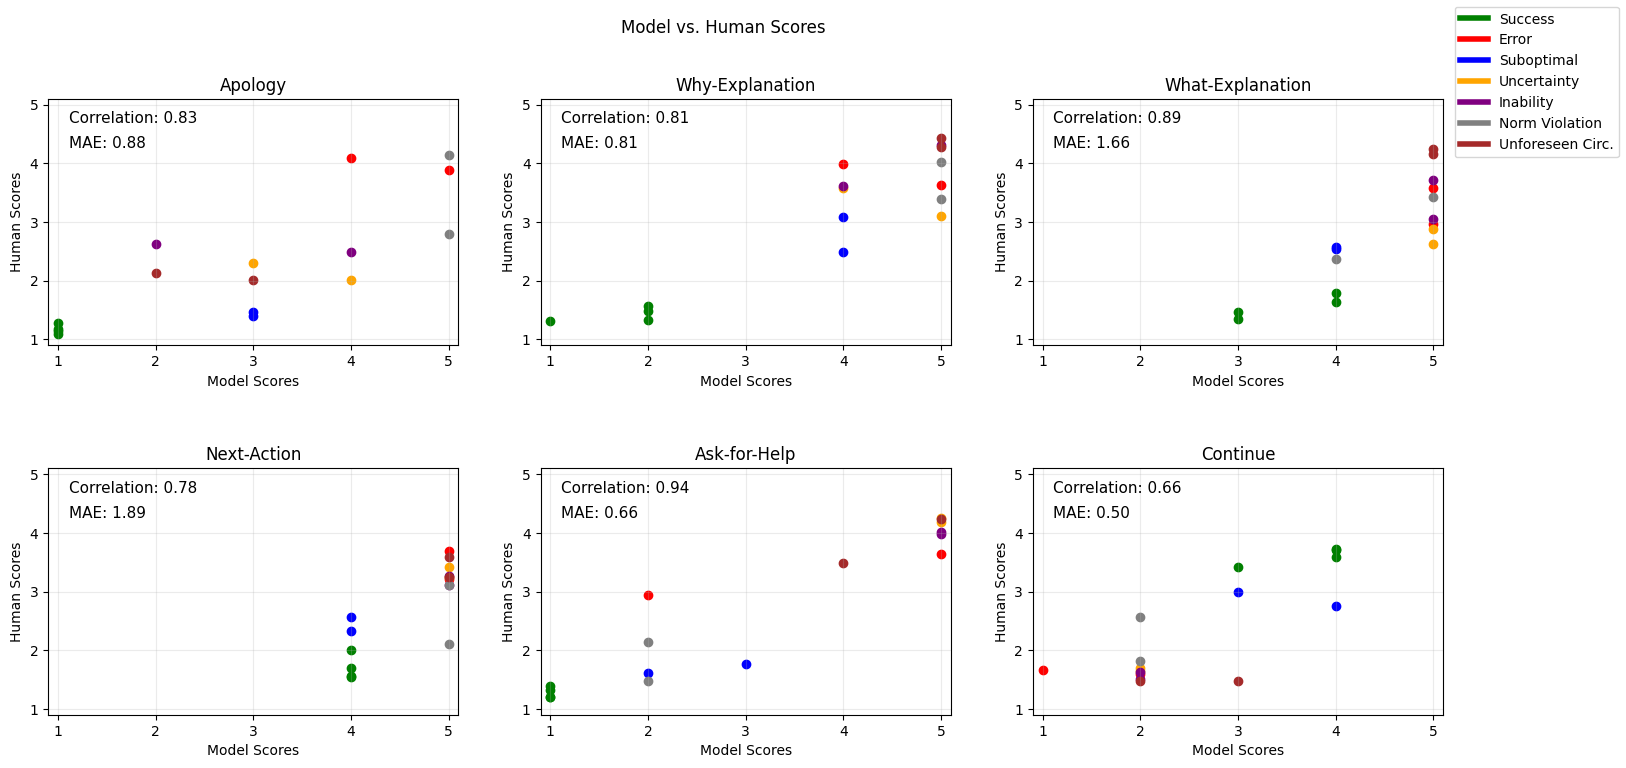

Suc ['What-Explanation', 'Next-Action', 'Continue'] ['Continue']
Suc ['Next-Action', 'Continue'] ['Continue']
Suc ['Next-Action'] ['Continue']
Suc ['What-Explanation', 'Next-Action', 'Continue'] ['Continue']
Err ['What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Apology']
Err ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action'] ['Apology']
Sub ['Why-Explanation', 'What-Explanation', 'Next-Action'] ['Continue']
Sub ['Why-Explanation', 'What-Explanation', 'Next-Action', 'Continue'] ['Why-Explanation']
Unc ['Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Ask-for-Help']
Unc ['What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Ask-for-Help']
Ina ['Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Why-Explanation']
Ina ['What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Ask-for-Help']
Norm ['Apology', 'Why-Explanation', 'Next-Action'] ['Why-Explanation']
Norm ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action'] ['Ap

In [12]:
corrs, p_vals, coor_labels = compute_correlations(model_scores_gpt4, HUMAN_AVG_RATINGS, plot=True, save_name="gpt_4_correlations")
all_p_values+=p_vals
all_correlations+=corrs
for l in coor_labels:
    all_corr_labels.append(l+"_gpt4")
print(get_best_action(model_scores_gpt4, HUMAN_AVG_RATINGS))

Apology
SignificanceResult(statistic=nan, pvalue=nan)
Why-Explanation
SignificanceResult(statistic=nan, pvalue=nan)
What-Explanation
SignificanceResult(statistic=nan, pvalue=nan)
Next-Action
SignificanceResult(statistic=nan, pvalue=nan)
Ask-for-Help
SignificanceResult(statistic=nan, pvalue=nan)
Continue
SignificanceResult(statistic=nan, pvalue=nan)


/opt/homebrew/anaconda3/envs/hrillms/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/opt/homebrew/anaconda3/envs/hrillms/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/opt/homebrew/anaconda3/envs/hrillms/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/opt/homebrew/anaconda3/envs/hrillms/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/opt/homebrew/anacon

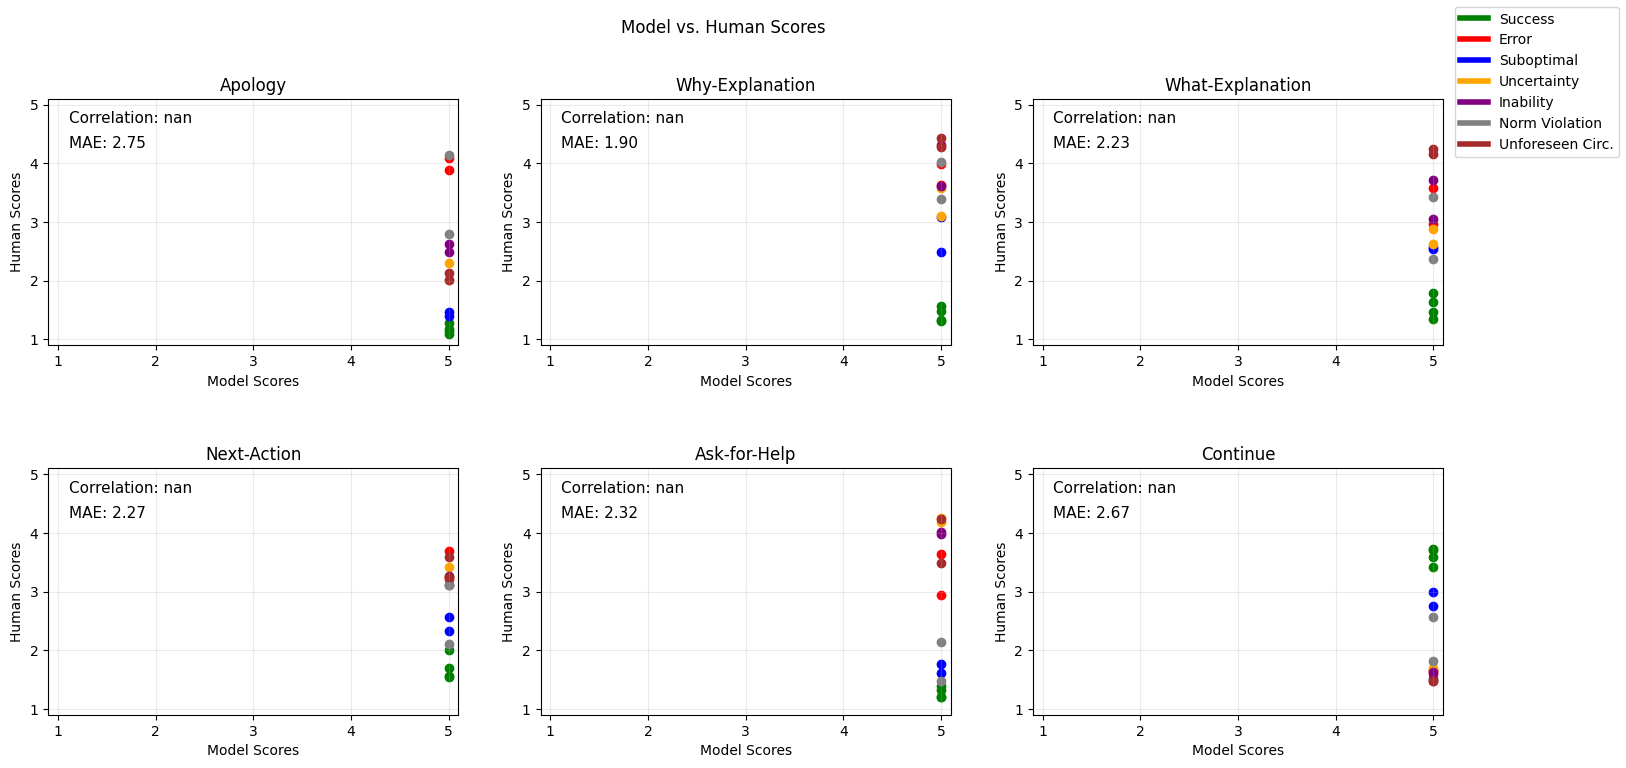

Suc ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Continue']
Suc ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Continue']
Suc ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Continue']
Suc ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Continue']
Err ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Apology']
Err ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Apology']
Sub ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Continue']
Sub ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Why-Explanation']
Unc ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Ask-for

In [13]:
corrs, p_vals, coor_labels = compute_correlations(model_scores_gpt3base, HUMAN_AVG_RATINGS, plot=True, save_name="gpt_3_correlations")
all_p_values+=p_vals
all_correlations+=corrs
for l in coor_labels:
    all_corr_labels.append(l+"_gpt3")
print(get_best_action(model_scores_gpt3base, HUMAN_AVG_RATINGS))

Apology
SignificanceResult(statistic=0.5970499426054858, pvalue=0.014611581693635361)
Why-Explanation
SignificanceResult(statistic=0.5392460061012022, pvalue=0.031114308306215612)
What-Explanation
SignificanceResult(statistic=0.399471747717828, pvalue=0.12529546277200618)
Next-Action
SignificanceResult(statistic=0.36896402776085446, pvalue=0.15962181562449568)
Ask-for-Help
SignificanceResult(statistic=0.6916843189735757, pvalue=0.00299461411750856)
Continue
SignificanceResult(statistic=0.6618722431936245, pvalue=0.005223817215164433)


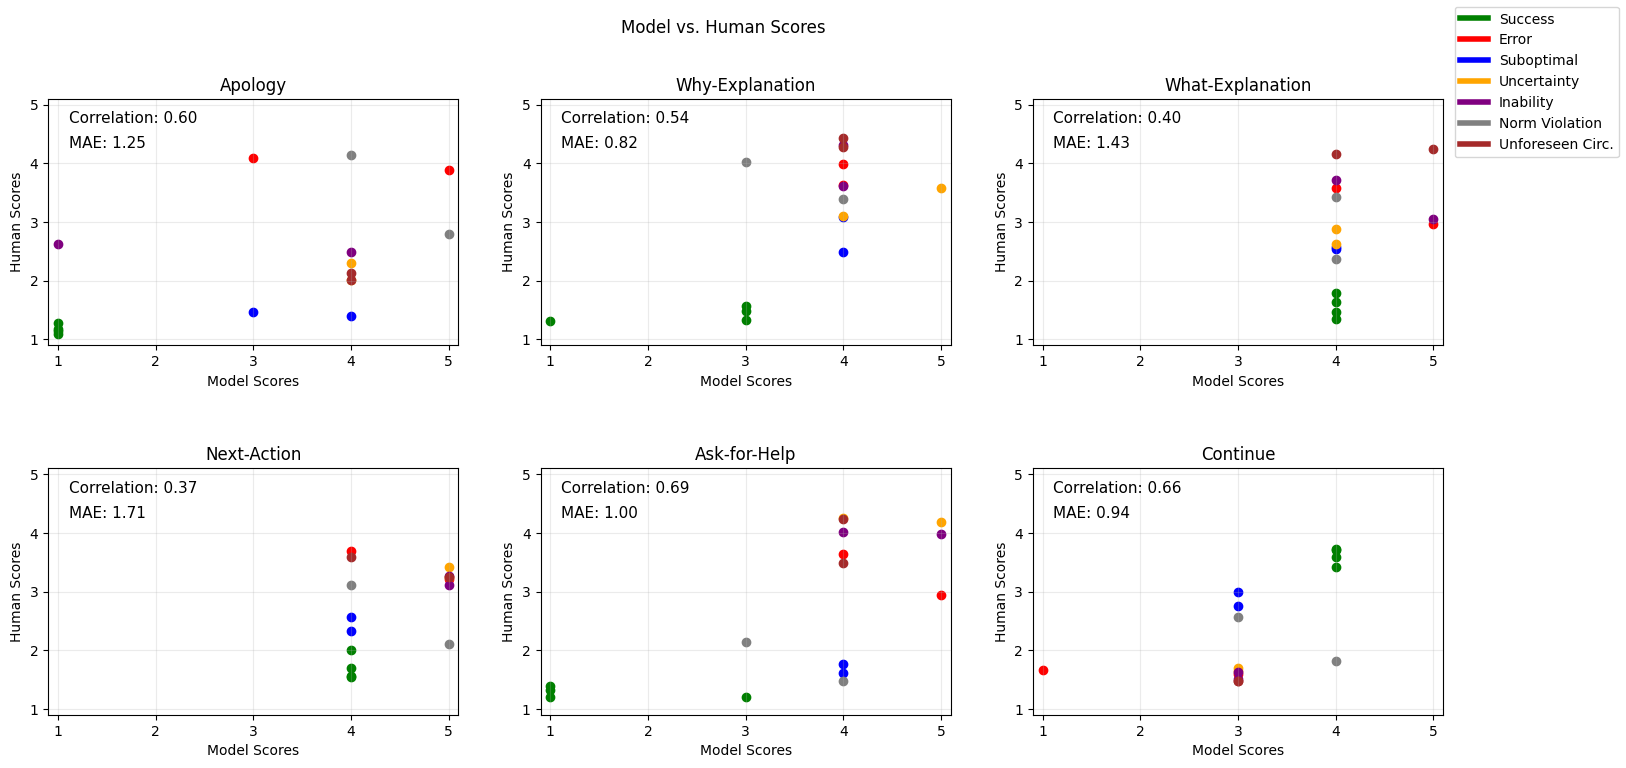

Suc ['What-Explanation', 'Next-Action', 'Continue'] ['Continue']
Suc ['Next-Action', 'Continue'] ['Continue']
Suc ['Next-Action'] ['Continue']
Suc ['What-Explanation', 'Next-Action', 'Continue'] ['Continue']
Err ['What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Apology']
Err ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action'] ['Apology']
Sub ['Why-Explanation', 'What-Explanation', 'Next-Action'] ['Continue']
Sub ['Why-Explanation', 'What-Explanation', 'Next-Action', 'Continue'] ['Why-Explanation']
Unc ['Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Ask-for-Help']
Unc ['What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Ask-for-Help']
Ina ['Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Why-Explanation']
Ina ['What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Ask-for-Help']
Norm ['Apology', 'Why-Explanation', 'Next-Action'] ['Why-Explanation']
Norm ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action'] ['Ap

In [14]:
corrs, p_vals, coor_labels = compute_correlations(model_scores_gpt35, HUMAN_AVG_RATINGS, plot=True, save_name="gpt_35_correlations")
all_p_values+=p_vals
all_correlations+=corrs
for l in coor_labels:
    all_corr_labels.append(l+"_gpt35")
print(get_best_action(model_scores_gpt4, HUMAN_AVG_RATINGS))

Apology
SignificanceResult(statistic=0.28697202159177576, pvalue=0.28119132432232985)
Why-Explanation
SignificanceResult(statistic=nan, pvalue=nan)
What-Explanation
SignificanceResult(statistic=nan, pvalue=nan)
Next-Action
SignificanceResult(statistic=nan, pvalue=nan)
Ask-for-Help
SignificanceResult(statistic=nan, pvalue=nan)
Continue
SignificanceResult(statistic=0.22958473452474443, pvalue=0.3923538549966641)


/opt/homebrew/anaconda3/envs/hrillms/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/opt/homebrew/anaconda3/envs/hrillms/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/opt/homebrew/anaconda3/envs/hrillms/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/opt/homebrew/anaconda3/envs/hrillms/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/opt/homebrew/anacon

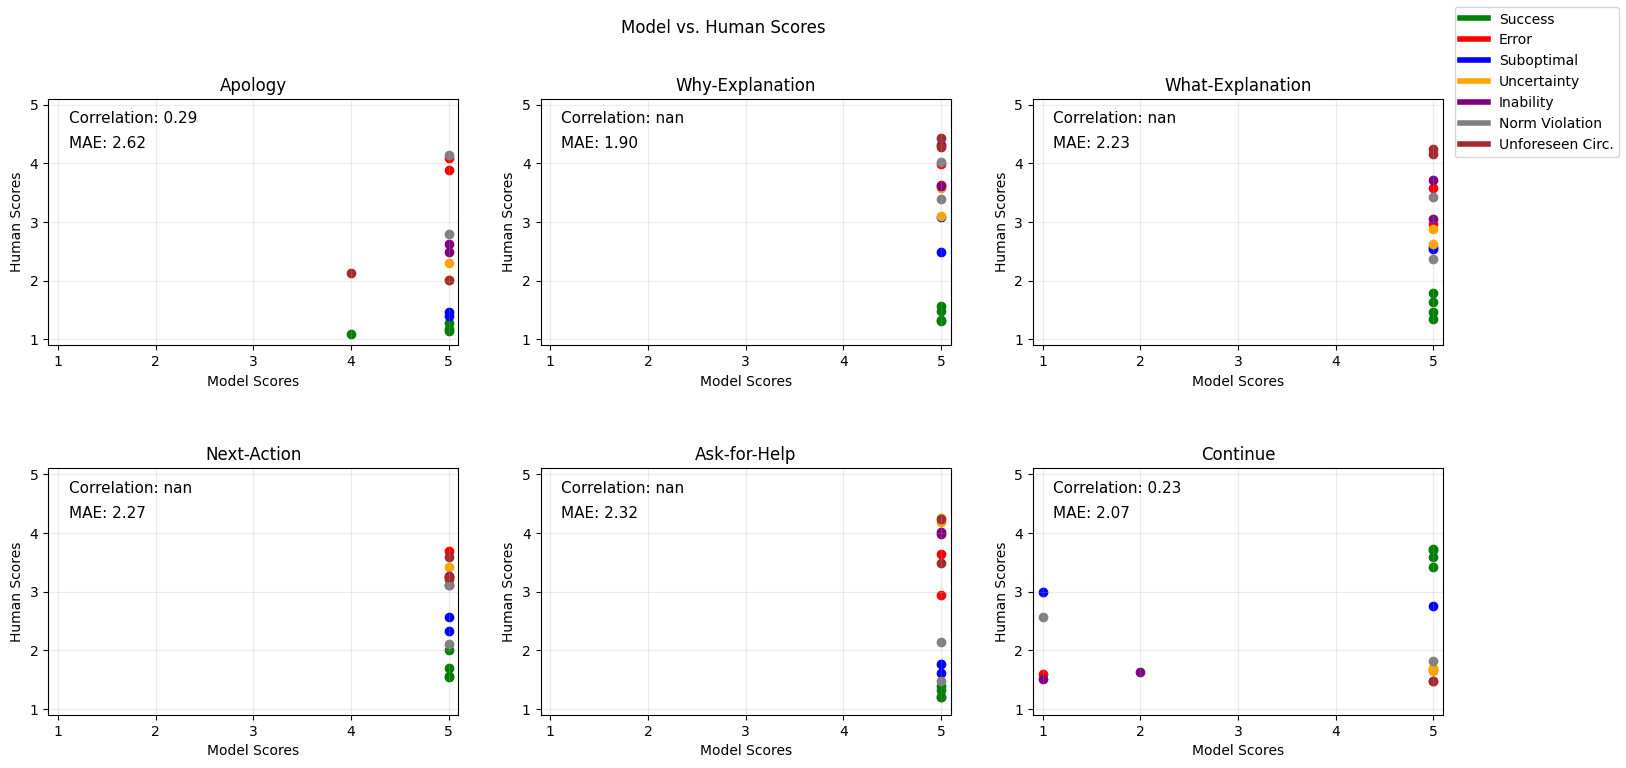

Suc ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Continue']
Suc ['Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Continue']
Suc ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Continue']
Suc ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Continue']
Err ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Apology']
Err ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Apology']
Sub ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Continue']
Sub ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Why-Explanation']
Unc ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Ask-for-Help']
Unc ['Apology', 'Why-Explan

In [15]:
corrs, p_vals, coor_labels = compute_correlations(models_scores_llama13, HUMAN_AVG_RATINGS, plot=True, save_name="llama_13_correlations")
all_p_values+=p_vals
all_correlations+=corrs
for l in coor_labels:
    all_corr_labels.append(l+"_llama13")
print(get_best_action(models_scores_llama13, HUMAN_AVG_RATINGS))

Apology
SignificanceResult(statistic=0.6140634384863434, pvalue=0.011389136839273818)
Why-Explanation
SignificanceResult(statistic=0.028005601680560196, pvalue=0.9179989706285087)
What-Explanation
SignificanceResult(statistic=0.08401680504168059, pvalue=0.7570527243204266)
Next-Action
SignificanceResult(statistic=0.5009794328681196, pvalue=0.048071080624166)
Ask-for-Help
SignificanceResult(statistic=0.7985035881290949, pvalue=0.00020831617119745246)
Continue
SignificanceResult(statistic=0.48263979992390627, pvalue=0.05828743663734339)


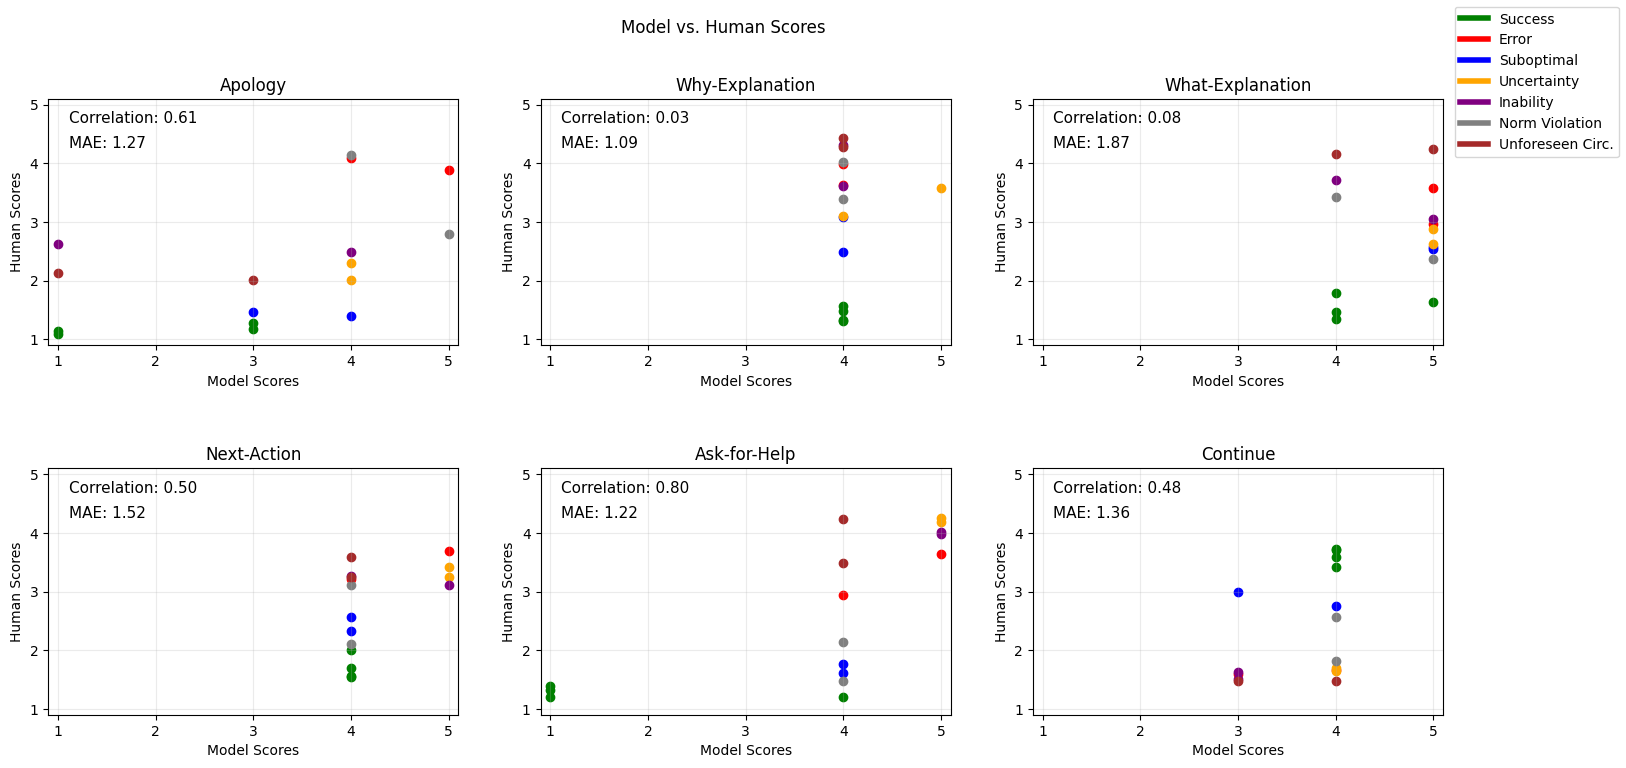

Suc ['Why-Explanation', 'What-Explanation', 'Next-Action', 'Continue'] ['Continue']
Suc ['Why-Explanation', 'What-Explanation', 'Next-Action', 'Continue'] ['Continue']
Suc ['Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Continue']
Suc ['What-Explanation'] ['Continue']
Err ['What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Apology']
Err ['Apology', 'What-Explanation'] ['Apology']
Sub ['What-Explanation'] ['Continue']
Sub ['What-Explanation'] ['Why-Explanation']
Unc ['What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Ask-for-Help']
Unc ['Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Ask-for-Help']
Ina ['Ask-for-Help'] ['Why-Explanation']
Ina ['What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Ask-for-Help']
Norm ['Apology', 'What-Explanation'] ['Why-Explanation']
Norm ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Apology']
Unfor ['Why-Explanation', 'What-Explanation', 'N

In [16]:
corrs, p_vals, coor_labels = compute_correlations(models_scores_llama70, HUMAN_AVG_RATINGS, plot=True, save_name="llama_70_correlations")
all_p_values+=p_vals
all_correlations+=corrs
for l in coor_labels:
    all_corr_labels.append(l+"_llama70")
print(get_best_action(models_scores_llama70, HUMAN_AVG_RATINGS))

In [16]:
p_vals_adj = multipletests(all_p_values, method='fdr_bh')
for i in range(len(all_corr_labels)):
    if p_vals_adj[1][i] < 0.05:
        print(all_corr_labels[i], all_correlations[i], p_vals_adj[1][i], "***")
    else:
        print(all_corr_labels[i], all_correlations[i], p_vals_adj[1][i])

Apology_gpt4 0.8281455036111414 0.0007438493114191491 ***
Why-Explanation_gpt4 0.8078293354998427 0.0011514838687608846 ***
What-Explanation_gpt4 0.8903072833710445 5.7251437569870147e-05 ***
Next-Action_gpt4 0.7841568470556856 0.0016179090584528637 ***
Ask-for-Help_gpt4 0.9433669362822658 1.2931228803587286e-06 ***
Continue_gpt4 0.6596782236843317 0.018098492660281507 ***
Apology_gpt3 0 1.0
Why-Explanation_gpt3 0 1.0
What-Explanation_gpt3 0 1.0
Next-Action_gpt3 0 1.0
Ask-for-Help_gpt3 0 1.0
Continue_gpt3 0 1.0
Apology_gpt35 0.5970499426054858 0.03984976825536917 ***
Why-Explanation_gpt35 0.5392460061012022 0.07778577076553903
What-Explanation_gpt35 0.399471747717828 0.25059092554401236
Next-Action_gpt35 0.36896402776085446 0.2992909042959294
Ask-for-Help_gpt35 0.6916843189735757 0.012834060503608113 ***
Continue_gpt35 0.6618722431936245 0.018098492660281507 ***
Apology_llama13 0.28697202159177576 0.49621998409822915
Why-Explanation_llama13 0 1.0
What-Explanation_llama13 0 1.0
Next-Act

In [17]:
# compute averages for each action type
all_scores={}
for key in HUMAN_AVG_RATINGS.keys():
    all_scores[key] = []
for i, label in enumerate(all_corr_labels):
    for key in HUMAN_AVG_RATINGS.keys():
        if key in label and all_correlations[i] != 0:
            all_scores[key].append(all_correlations[i])

for key in all_scores.keys():
    print(key, all_scores[key], np.mean(all_scores[key]))

# compute averages per model
avg_score_model={"llama-13":[], "llama-70":[], "gpt-3":[], "gpt-3.5":[], "gpt-4":[]}
for i, label in enumerate(all_corr_labels):
    if "llama13" in label:
        avg_score_model["llama-13"].append(all_correlations[i])
    elif "llama70" in label:
        avg_score_model["llama-70"].append(all_correlations[i])
    elif "gpt3 " in label:
        avg_score_model["gpt-3"].append(all_correlations[i])
    elif "gpt35" in label:
        avg_score_model["gpt-3.5"].append(all_correlations[i])
    elif "gpt4" in label:
        avg_score_model["gpt-4"].append(all_correlations[i])

for key in avg_score_model.keys():
    print(key, avg_score_model[key], np.mean(avg_score_model[key]))



Apology [0.8281455036111414, 0.5970499426054858, 0.28697202159177576, 0.6140634384863434] 0.5815577265736865
Why-Explanation [0.8078293354998427, 0.5392460061012022, 0.028005601680560196] 0.4583603144272017
What-Explanation [0.8903072833710445, 0.399471747717828, 0.08401680504168059] 0.45793194537685106
Next-Action [0.7841568470556856, 0.36896402776085446, 0.5009794328681196] 0.5513667692282199
Ask-for-Help [0.9433669362822658, 0.6916843189735757, 0.7985035881290949] 0.8111849477949789
Continue [0.6596782236843317, 0.6618722431936245, 0.22958473452474443, 0.48263979992390627] 0.5084437503316517
llama-13 [0.28697202159177576, 0, 0, 0, 0, 0.22958473452474443] 0.0860927926860867
llama-70 [0.6140634384863434, 0.028005601680560196, 0.08401680504168059, 0.5009794328681196, 0.7985035881290949, 0.48263979992390627] 0.4180347776882842
gpt-3 [] nan
gpt-3.5 [0.5970499426054858, 0.5392460061012022, 0.399471747717828, 0.36896402776085446, 0.6916843189735757, 0.6618722431936245] 0.5430480477254285
g

/opt/homebrew/anaconda3/envs/hrillms/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/envs/hrillms/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### CoT

Apology
SignificanceResult(statistic=0.7836580199498389, pvalue=0.0003283822442313817)
Why-Explanation
SignificanceResult(statistic=0.7941113657782815, pvalue=0.0002392377182672386)
What-Explanation
SignificanceResult(statistic=0.4201093918353521, pvalue=0.10520485418609285)
Next-Action
SignificanceResult(statistic=0.370579511163097, pvalue=0.15766100954047366)
Ask-for-Help
SignificanceResult(statistic=0.9326294264384024, pvalue=1.4117780284037902e-07)
Continue
SignificanceResult(statistic=0.717075680011669, pvalue=0.0017694499945401902)


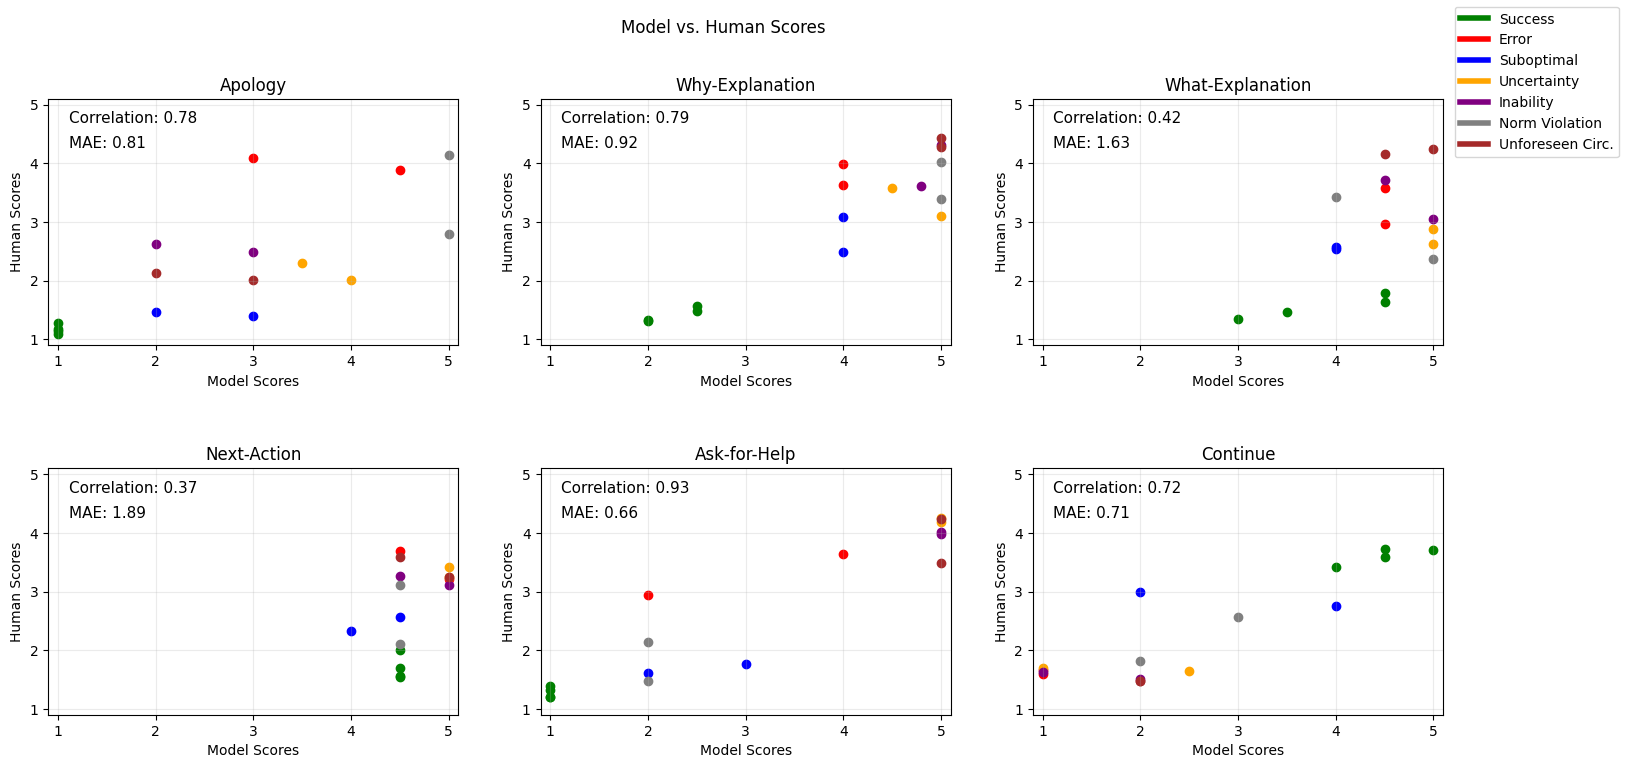

[0.7836580199498389, 0.7941113657782815, 0.4201093918353521, 0.370579511163097, 0.9326294264384024, 0.717075680011669]
Average: 0.6696938991961067


In [18]:
corrs, _, _ = compute_correlations(models_scores_gpt4_cot, HUMAN_AVG_RATINGS, plot=True)
# average 
print(corrs)
print("Average:", np.mean(corrs))

Apology
SignificanceResult(statistic=0.8907239183713265, pvalue=3.7206869389226608e-06)
Why-Explanation
SignificanceResult(statistic=0.7299564522902233, pvalue=0.0013263895206605562)
What-Explanation
SignificanceResult(statistic=0.5222915897416529, pvalue=0.03794667152171896)
Next-Action
SignificanceResult(statistic=0.3891716143997985, pvalue=0.13625396539135176)
Ask-for-Help
SignificanceResult(statistic=0.9290908779099407, pvalue=2.0009689029595942e-07)
Continue
SignificanceResult(statistic=0.5345041318566651, pvalue=0.03292250921889397)


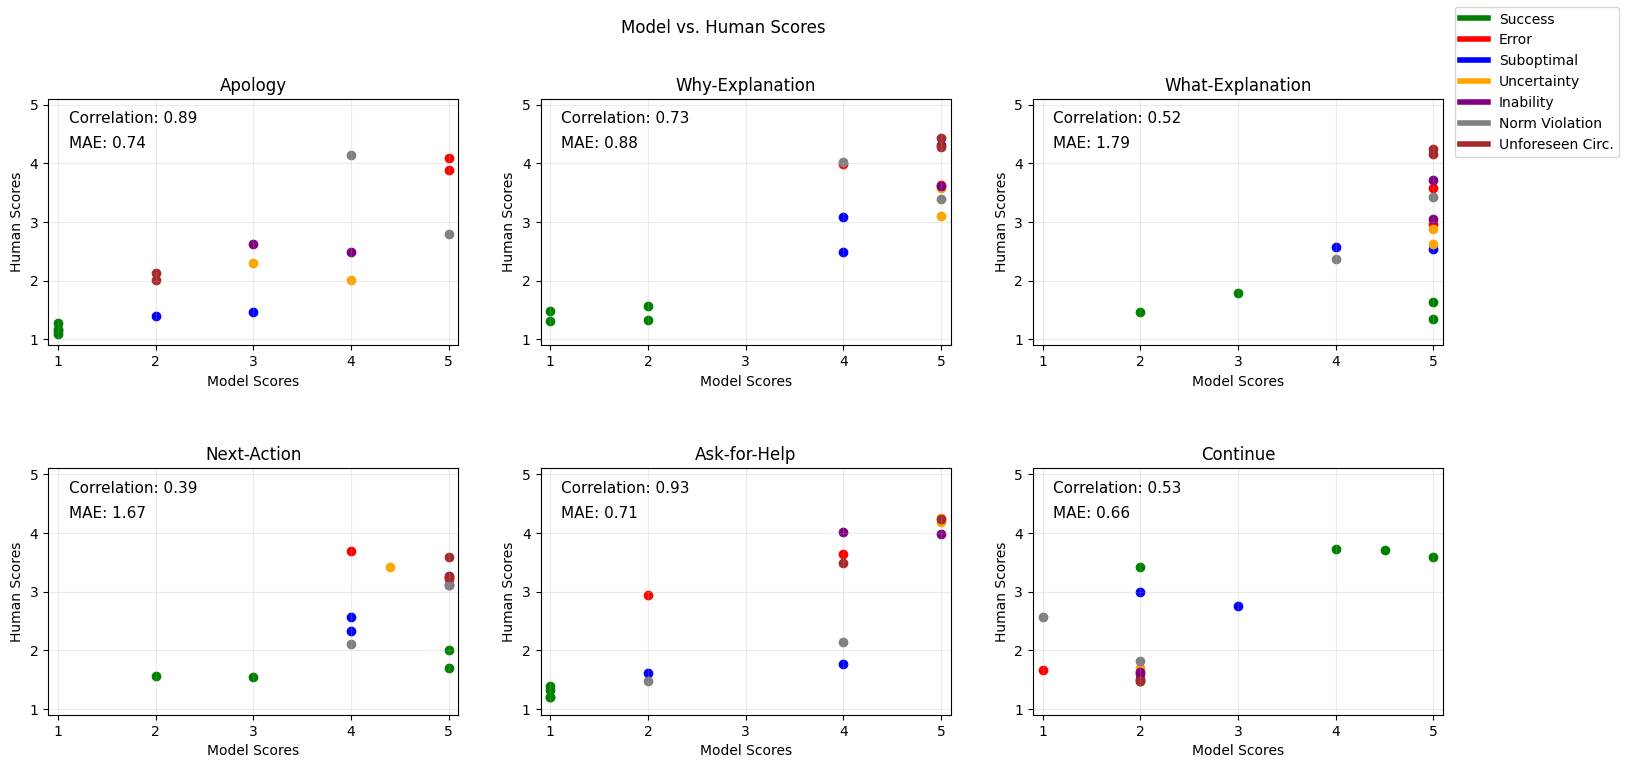

[0.8907239183713265, 0.7299564522902233, 0.5222915897416529, 0.3891716143997985, 0.9290908779099407, 0.5345041318566651]
Average: 0.6659564307616012


In [19]:
corrs, _, _ = compute_correlations(models_scores_gpt4_cot_sys, HUMAN_AVG_RATINGS, plot=True)
# average 
print(corrs)
print("Average:", np.mean(corrs))

### Extra Graph for Paper

In [112]:
SITUATION_TYPES=["Suc", "Err", "Unc", "Ina", "Sub", "Norm", "Unfor"]
PREF_MAPPING = {"Apology": "1", "Why-Expl.":"2", "What-Expl.":"3", "Next-Action":"4", "Ask-for-Help":"5", "Continue":"6"} 

def get_preference_rating(preference):
    all_pref_columns=exp1_df.filter(regex='^ResponsePref').columns
    dict_pref_ratings = {}
    for sit in SITUATION_TYPES:
        dict_pref_ratings[sit] = []  
    ending = PREF_MAPPING[preference]
    for sit in SITUATION_TYPES:
        print(sit)
        # get columns for that specific situation
        pref_columns_sit = [col for col in all_pref_columns if sit in col]
        # get columns for that specific pref
        pref_columns_sit_ending = [col for col in pref_columns_sit if col.endswith(ending)]
        # get mean per index/row for df[pref_columns_sit_ending]
        print(exp1_df[pref_columns_sit_ending].mean(axis=1))
        dict_pref_ratings[sit] = exp1_df[pref_columns_sit_ending].mean(axis=1).tolist()
    
    return dict_pref_ratings
            

def violin_plots(pref_per_sit_dict, pref):
    fontsize=16
    # visualize as boxplot or violin plot with one entry per situation type
    plt.figure(figsize=(7,5))
    #plt.title("Preference for Why-Explanation")
    plt.ylabel("Preference Score")
    plt.xlabel("Situation Type")

    plt.ylim(1, 5.1)
    plt.yticks(np.arange(1, 5.5, 1))
    # violinplot 
    # sort dict by mean    
    sorted_dict = {k: v for k, v in sorted(pref_per_sit_dict.items(), key=lambda item: np.mean(item[1]))}
    # get resorted index (integer)
    sorted_index = [SITUATION_TYPES.index(k) for k in sorted_dict.keys()]
    print("here", len(sorted_index), sorted_index)
    # resort existing SITUATION_TYPE_LABELS based on the same index changes
    SITUATION_TYPE_LABELS=["Success", "Error", "Uncertainty", "Inability", "Suboptimality", "Norm Violation", "Unforseen Event"]
    sorted_labels = [SITUATION_TYPE_LABELS[i] for i in sorted_index]

    vp  = plt.violinplot(sorted_dict.values(), showmeans=True, showmedians=False, showextrema=False)
    for pc in vp['bodies']:
        pc.set_facecolor('lightblue')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    ax = plt.gca()
    ax.set_xticklabels(sorted_labels)
    ax.set_xticks(np.arange(1, 8, 1))
    # make x and y label bold
    ax.set_xlabel(ax.get_xlabel(), fontweight='bold', fontsize=fontsize+2)
    ax.set_ylabel(ax.get_ylabel(), fontweight='bold', fontsize=fontsize+2)
    # grid
    plt.grid(axis='y', alpha=0.3)
    # increase font size
    plt.yticks(fontsize=fontsize)
    # tilt x axis labels
    plt.xticks(rotation=25, ha='right', rotation_mode='anchor', fontsize=fontsize)
    bbox = dict(boxstyle="round", ec="grey", fc="grey", alpha=0.2, pad = 0.1)
    plt.setp(ax.get_xticklabels(), bbox=bbox)

    # add mean bars based on GPT-4 scores
    model_avg = {"Suc": [], "Sub": [], "Unc": [], "Norm": [], "Err": [], "Ina": [], "Unfor": []}
    for i in range(16):
        # based on scenario_labels_short sort the scores into the right category
        label = scenario_labels_short[i]
        model_avg[label].append(model_scores_gpt4[pref][i])

    # plot the average scores
    for i, key in enumerate(sorted_dict.keys()):
        plt.plot(i+1, np.mean(model_avg[key]), 'x', color="black", label="Model", markersize=13, markeredgewidth=2)
    

    # add completly manual legend that says black x = model and light blue = human
    #plt.legend with "Avg. Model Answer" = x and -- = human
    x_sign= plt.Line2D([0], [0], color='black', marker='x', markersize=13, markeredgewidth=2, label='Avg. GPT-4 Answer', linestyle='')
    human_line = plt.Line2D([0], [0], color='blue', label='Avg. Human Answer')
    # no background 
    plt.legend(handles=[x_sign, human_line], loc='lower right', fontsize=fontsize)
    plt.show()

Suc
2      2.50
3      1.75
5      2.00
6      1.00
7      1.00
       ... 
192    1.00
193    1.00
194    3.00
195    1.75
196    1.25
Length: 186, dtype: float64
Err
2      4.0
3      2.0
5      5.0
6      3.0
7      4.5
      ... 
192    4.0
193    2.5
194    5.0
195    4.5
196    4.5
Length: 186, dtype: float64
Unc
2      4.5
3      3.0
5      5.0
6      1.0
7      3.5
      ... 
192    4.5
193    3.0
194    5.0
195    3.5
196    4.5
Length: 186, dtype: float64
Ina
2      4.5
3      2.5
5      5.0
6      1.0
7      5.0
      ... 
192    4.0
193    1.5
194    5.0
195    4.5
196    5.0
Length: 186, dtype: float64
Sub
2      4.5
3      2.0
5      4.0
6      2.5
7      4.5
      ... 
192    4.0
193    1.0
194    3.0
195    5.0
196    5.0
Length: 186, dtype: float64
Norm
2      5.0
3      1.5
5      5.0
6      2.5
7      4.5
      ... 
192    5.0
193    1.0
194    5.0
195    4.0
196    4.5
Length: 186, dtype: float64
Unfor
2      5.0
3      4.0
5      5.0
6      3.0
7      5.0
      ...

/var/folders/bv/9t03hlvd6jv_vzfmf4gqhkfm0000gn/T/ipykernel_7660/634879330.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sorted_labels)


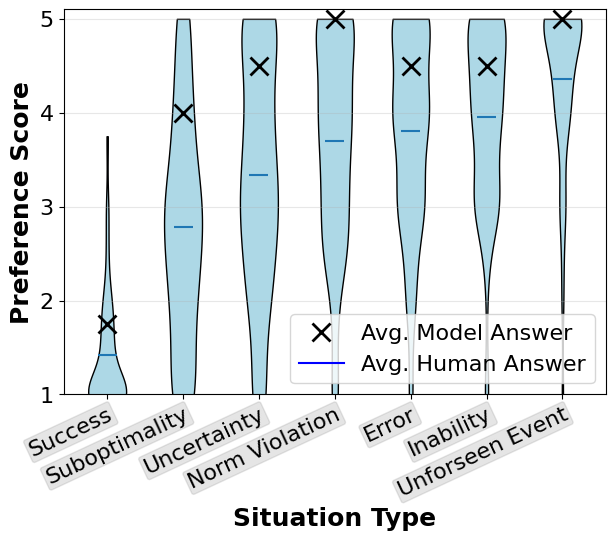

In [113]:
pref_per_sit_dict=get_preference_rating("Why-Expl.")
violin_plots(pref_per_sit_dict, pref="Why-Explanation")

Suc
2      1.00
3      1.75
5      1.00
6      1.00
7      1.50
       ... 
192    1.00
193    1.00
194    1.00
195    1.75
196    1.75
Length: 186, dtype: float64
Err
2      1.5
3      1.5
5      5.0
6      3.0
7      4.5
      ... 
192    4.5
193    3.0
194    4.0
195    2.5
196    4.5
Length: 186, dtype: float64
Unc
2      3.5
3      3.0
5      3.0
6      5.0
7      4.5
      ... 
192    5.0
193    4.0
194    4.5
195    3.0
196    4.5
Length: 186, dtype: float64
Ina
2      4.0
3      4.0
5      1.0
6      5.0
7      4.5
      ... 
192    4.5
193    2.5
194    4.5
195    3.5
196    4.0
Length: 186, dtype: float64
Sub
2      1.5
3      2.0
5      1.0
6      1.0
7      2.5
      ... 
192    3.5
193    1.0
194    1.0
195    3.5
196    3.5
Length: 186, dtype: float64
Norm
2      2.5
3      1.5
5      1.0
6      1.0
7      3.0
      ... 
192    3.5
193    1.0
194    3.0
195    2.0
196    2.5
Length: 186, dtype: float64
Unfor
2      2.0
3      3.0
5      5.0
6      1.0
7      4.0
      ...

/var/folders/bv/9t03hlvd6jv_vzfmf4gqhkfm0000gn/T/ipykernel_7660/634879330.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sorted_labels)


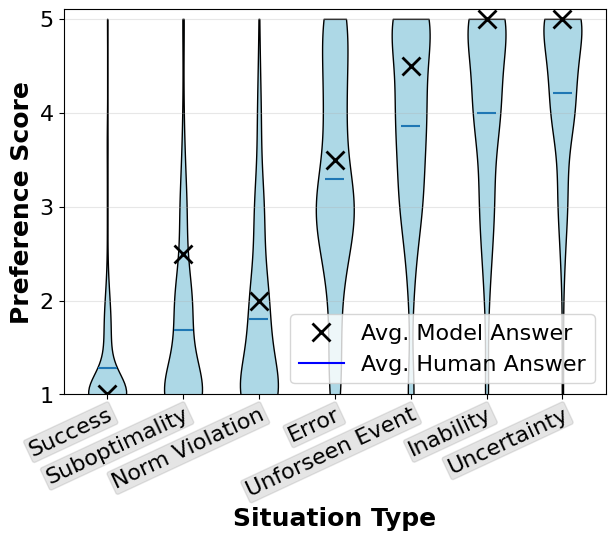

In [114]:
pref_per_sit_dict=get_preference_rating("Ask-for-Help")
violin_plots(pref_per_sit_dict, pref="Ask-for-Help")